### Subtomogram Alignment and Averaging

In [69]:
import numpy as np
import torch
import scipy

In [70]:
ribosome = '/pscratch/sd/h/hnjones/denoise_et/ribosome'
cryocare = ribosome + '/cryocare'
xray = '/global/cfs/projectdirs/xray/kpande/et_denoising/ribosome'
ddw = '/global/cfs/projectdirs/xray/kpande/et_denoising/ribosome/ddw/refined_tomo_full.mrc'
!source ~/.bashrc
!export PYTHONPATH=$PYTHONPATH:/global/homes/h/hnjones/
!source $HOME/.bashrc
!source /global/homes/h/hnjones/.bashrc
!echo $PYTHONPATH
!echo $PATH

import os

cryocare_10k = cryocare + '/10_run/denoised_10k.rec/cryocare_prediction.mrc'
cryocare_50k = cryocare + '/50_run/denoised_50k.rec/cryocare_prediction.mrc'
ground_truth = '/global/cfs/projectdirs/xray/kpande/et_denoising/ribosome/noise_free/noisefree_full_rec.mrc'
volume = xray + '/TEM_simulator/volume.mrc'

import mrcfile
import torch, numpy as np
import matplotlib.pyplot as plt

/opt/nersc/pymon:/global/cfs/projectdirs/m4055/kpande:/global/homes/h/hnjones/
/global/common/software/nersc9/jupyter/ex/24-05/nersc-utils:/opt/nersc/pe/bin:/global/common/software/nersc/bin:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/cuda/12.2/compute-sanitizer:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/cuda/12.2/bin:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/cuda/12.2/libnvvp:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/profilers/Nsight_Compute:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/profilers/Nsight_Systems/bin:/opt/cray/pe/perftools/23.12.0/bin:/opt/cray/pe/papi/7.0.1.2/bin:/opt/cray/pe/craype/2.7.30/bin:/opt/cray/pe/mpich/8.1.28/ofi/gnu/12.3/bin:/opt/cray/pe/mpich/8.1.28/bin:/opt/cray/libfabric/1.15.2.0/bin:/usr/local/bin:/usr/bin:/bin:/usr/lib/mit/bin:/opt/cray/pe/bin


In [71]:
gtruth = torch.tensor(mrcfile.read(ground_truth))
cryocare_10 = torch.tensor(mrcfile.read(cryocare_10k))
cryocare_50 = torch.tensor(mrcfile.read(cryocare_50k))
ddw = torch.tensor(mrcfile.read(ddw))
volume = torch.tensor(mrcfile.read(volume))

In [72]:
print(gtruth.shape, cryocare_10.shape, cryocare_50.shape, ddw.shape, volume.shape)

torch.Size([2000, 200, 2000]) torch.Size([2000, 200, 2000]) torch.Size([200, 2000, 2000]) torch.Size([200, 2000, 2000]) torch.Size([200, 1000, 1000])


In [73]:
#coordinates are output centered in nm before magnification
coords = torch.Tensor(np.genfromtxt('/global/cfs/projectdirs/xray/kpande/et_denoising/ribosome/ribo_coordinates.txt', skip_header = 2))

## Rotation based on Euler Angles
from 
https://pytorch3d.readthedocs.io/en/latest/_modules/pytorch3d/transforms/rotation_conversions.html#euler_angles_to_matrix


Rotation matrix by extrinsic Euler angles
Consider the rotation so the rotation around $z$ by $\phi$, then around $x$ by $\theta$, and then around $z$ again by $\psi$ as done in TEM-simulator, the rotation is matrix multiplication $\psi_z \theta_x \phi_z$, where the subscript denotes the extrinsic axis of rotation and each rotation is a 3x3 matrix?

The rotation matrices about external axes are given by 


\begin{align*}
\phi_x &= 
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos \phi & -\sin \phi \\
 0 & \sin \phi & \cos \phi \\
\end{bmatrix} \\
\phi_y &= 
\begin{bmatrix}
\cos \phi & 0 & \sin \phi \\
 0 & 1 & 0 \\
-\sin \phi & 0 & \cos \phi \\
\end{bmatrix} \\
\phi_z &= 
\begin{bmatrix}
\cos \phi & -\sin \phi & 0 \\
\sin \phi & \cos \phi & 0 \\
 0 & 0 & 1
\end{bmatrix}
\end{align*}

Thus, since TEM-simulator uses z-x-z rotations, the rotation matrix for  $\psi_z \theta_x \phi_z$ is given by 
\begin{align*}
\begin{bmatrix}
\cos \psi & -\sin \psi & 0 \\
\sin \psi & \cos \psi & 0 \\
 0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos \theta & -\sin \theta \\
 0 & \sin \theta & \cos \theta \\
\end{bmatrix}
\begin{bmatrix}
\cos \phi & -\sin \phi & 0 \\
\sin \phi & \cos \phi & 0 \\
 0 & 0 & 1 \\
\end{bmatrix} \\
= \begin{bmatrix}
\cos \psi & -\sin \psi & 0 \\
\sin \psi & \cos \psi & 0 \\
 0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
\cos \phi & -\sin \phi & 0 \\
\cos \theta \sin \phi & \cos \theta \cos \phi & -\sin \theta\\
\sin \theta \sin \phi & \sin \theta \cos \phi & \cos \theta \\
\end{bmatrix} \\
= \begin{bmatrix}
\cos \psi \cos \phi - \sin \psi \cos \theta \sin \phi & -  \cos \psi \sin \phi -\sin \psi  \cos \theta \cos \phi & \sin \psi \sin \theta \\
\sin \psi \cos \phi + \cos \psi \cos \theta \sin \phi & -\sin \psi \sin \phi  + \cos \psi  \cos \theta \cos \phi & -\cos \psi \sin \theta \\
\sin \theta \sin \phi & \sin \theta  \cos \phi & \cos \theta \\
\end{bmatrix}
\end{align*}

In [74]:
#make our rotation matrix
def angles_to_matrix(angles: torch.Tensor)-> torch.Tensor:
    assert angles.shape[0] == 3
    phi   = angles[0] * torch.pi / 180
    theta = angles[1] * torch.pi / 180
    psi   = angles[2] * torch.pi / 180
    
    sinphi = torch.sin(phi)
    cosphi = torch.cos(phi)
    
    sintheta = torch.sin(theta)
    costheta = torch.cos(theta)
    
    sinpsi = torch.sin(psi)
    cospsi = torch.cos(psi)
    
    r_mat = torch.Tensor([[cospsi * cosphi - (sinpsi * costheta * sinphi), 
                            - (cospsi * sinphi) - (sinpsi * costheta * cosphi),
                            sinpsi * sintheta],
                           [(sinpsi * cosphi) + (cospsi * costheta * sinphi),
                            -(sinpsi * sinphi) + (cospsi * costheta * cosphi),
                            - (cospsi * sintheta)],
                           [sintheta * sinphi, sintheta * cosphi, costheta]])
    return r_mat

In [75]:
## practice
practice_subtomo = torch.zeros((11,11,11))
#linspaces = torch.linspace(-5, 5, 10)
linspaces = torch.arange(-5, 6, step = 1, dtype = torch.float32)
meshgrid = torch.meshgrid((linspaces, linspaces, linspaces))
practice_subtomo[torch.sqrt((meshgrid[0] - 3) ** 2 + (meshgrid[1] -1)**2) < 3] = 1
x = torch.flatten(meshgrid[0])
y = torch.flatten(meshgrid[1])
z = torch.flatten(meshgrid[2])
vecs = torch.stack([x,y,z])
print(practice_subtomo[:,:, 5].numpy())
trial_angles = torch.Tensor([90, 90, 90])
matrix = angles_to_matrix(trial_angles)
print(torch.max(meshgrid[0]), torch.min(meshgrid[0]))
print(torch.max(meshgrid[1]), torch.min(meshgrid[1]))
print(torch.max(meshgrid[2]), torch.min(meshgrid[2]))
rotated = torch.matmul(matrix, vecs)
back_to_grid = torch.unflatten(rotated, dim = 1, sizes = (11, 11, 11))
conversion = scipy.interpolate.RegularGridInterpolator((linspaces.numpy(), linspaces.numpy(), linspaces.numpy()), practice_subtomo.numpy())
print(torch.max(rotated[0]), torch.min(rotated[0]))
print(torch.max(rotated[1]), torch.min(rotated[1]))
print(torch.max(rotated[2]), torch.min(rotated[2]))
back_to_grid
interpolation = conversion((torch.round(back_to_grid[0], decimals = 1).numpy(),
                                  torch.round(back_to_grid[1], decimals = 1).numpy(),
                                    torch.round(back_to_grid[2], decimals = 1).numpy()))
print(interpolation[:,:, 8])

#print(torch.unflatten(rotated[0], sizes = (10, 10, 10)), 'unflattened')
#print(rotated(

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.]]
tensor(5.) tensor(-5.)
tensor(5.) tensor(-5.)
tensor(5.) tensor(-5.)
tensor(5.0000) tensor(-5.0000)
tensor(5.) tensor(-5.)
tensor(5.) tensor(-5.)
[[0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]]


## Work on rotating subtomo
tensor([1810, 1761,   54], dtype=torch.int32)
size of subtomo (115, 244, 244)

Ideally the subtomo is 2* ribo_pixel radius, 2* ribo_pixel_diameter, 2* ribo_pixel_diamter in shape
ribo_pixel_radius = 61



### Rotation and Interpolation in Fourier space

61 pixel_radius
39 neighbor distance
tensor(12.9934) max Z
tensor(-12.9851) min Z
picked 18 particles


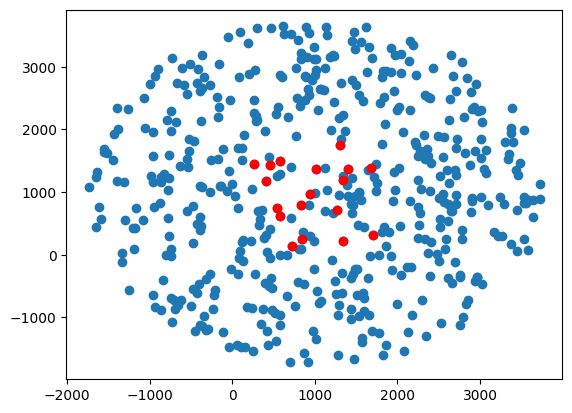

tensor(77.8000)


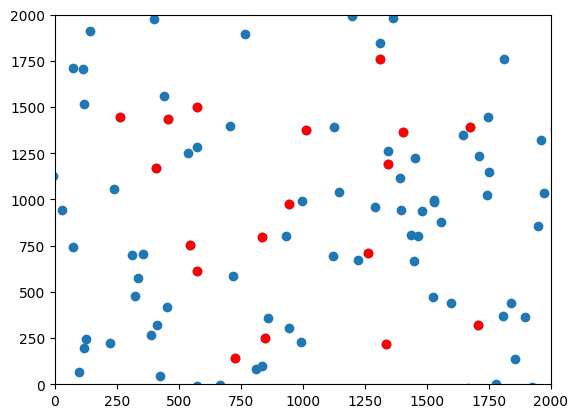

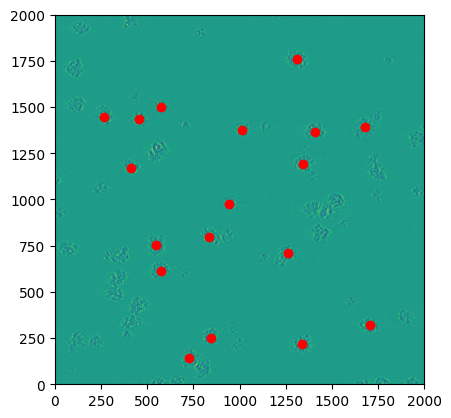

In [76]:
#80S ribosomes have diameters up to 300-320 A which is 30-32 nm
#We know our tem simulator uses magnification 
#750000 with detector size 16000 nm
magnification = 75000
detector_size_nm = 16000
ribosome_radius = 13 # nm
factor = magnification / detector_size_nm
ribosome_diameter = 2 * ribosome_radius
ribo_pixel_radius = int(torch.round(torch.Tensor([factor * ribosome_radius])))
ribo_pixel_diameter = 2 * ribo_pixel_radius
print(ribo_pixel_radius, 'pixel_radius')
print(ribosome_diameter + ribosome_radius, 'neighbor distance')
correct_size = torch.Size([200, 2000, 2000]) #z, y, x

#we only need to crop in the x and y planes



def check_transpose(in_tensor: torch.Tensor, correct_shape: torch.Size):
    if in_tensor.shape != correct_shape:
        return torch.transpose(in_tensor, 0, 1)
    return in_tensor

gtruth = check_transpose(gtruth, correct_size)

particle_file = '/global/cfs/projectdirs/xray/kpande/et_denoising/ribosome/ribo_coordinates.txt'
coords = torch.Tensor(np.genfromtxt(particle_file, skip_header = 2))
#orientations = coords[:, -3:] 
#coords = coords[:,:3]
print(torch.max(coords[:,2]), 'max Z')
print(torch.min(coords[:,2]), 'min Z')

def pick_particles(coords: torch.Tensor):
    first_mask = coords[((torch.abs(coords[:,0]) + ribosome_diameter) * factor <= correct_size[2]/2) \
                        & ((torch.abs(coords[:,1]) + ribosome_diameter) * factor <= correct_size[1]/2)\
                       & ((torch.abs(coords[:,2]) + ribosome_radius) * factor <= correct_size[0]/2)] #radius for the z axis
    #first_mask = coords[((torch.abs(coords[:,0]) + ribosome_diameter) * factor <= correct_size[1]/2) \
    #                    & ((torch.abs(coords[:,1]) + ribosome_diameter) * factor <= correct_size[2]/2)]
    upper_distance_matrix = torch.triu(torch.cdist(first_mask[:,:3], first_mask[:,:3], p=2) > ribosome_diameter)
    final_mask = ((upper_distance_matrix + torch.transpose(upper_distance_matrix, 0, 1)).sum(dim = 0) == upper_distance_matrix.shape[0]-1)
    coords = first_mask[final_mask]
    return coords

picked_coords = pick_particles(coords)

print(f"picked {int(picked_coords.shape[0])} particles")
plt.scatter(coords[:,0] * factor + 1000, coords[:,1] * factor + 1000)
plt.scatter(picked_coords[:,0] * factor + 1000, picked_coords[:,1] * factor + 1000, c= 'r')
plt.show()
#print minimum distance of kept particles
print(torch.min(torch.cdist(picked_coords, picked_coords, p = 2)[torch.triu(torch.cdist(picked_coords, picked_coords, p = 2)> 0.0)]))
plt.scatter(coords[:,0] * factor + 1000, coords[:,1] * factor + 1000)
plt.scatter(picked_coords[:,0] * factor + 1000, picked_coords[:,1] * factor + 1000, c= 'r')
plt.xlim(0,2000)
plt.ylim(0,2000)
plt.show()
plt.imshow(gtruth[100, :,:])
plt.scatter(picked_coords[:,0] * factor + 1000, picked_coords[:,1] * factor + 1000, c= 'r')

plt.xlim(0,2000)
plt.ylim(0,2000)
plt.show()

In [77]:
import numpy as np
def new_extract_subtomos(volume: torch.Tensor, picked_coordinates: torch.Tensor):
    tensor_of_subtomos = np.empty(shape = int(picked_coordinates.shape[0]), dtype = object)
    print(tensor_of_subtomos.shape)
    print(volume.shape)
    tensor_of_coords = torch.empty(size = (int(picked_coordinates.shape[0]),3))
    for particle in range(int(picked_coordinates.shape[0])):
        pixel_coord_float = torch.Tensor([picked_coordinates[particle,0] * factor + volume.shape[-1]/2,
                                          picked_coordinates[particle,1] * factor + volume.shape[-2]/2,
                                         volume.shape[-3] - (picked_coordinates[particle,2] * factor + volume.shape[-3]/2)]) #reverse the order of the z axis
        pixel_coord = torch.round(pixel_coord_float).int()
        tensor_of_coords[particle] = pixel_coord_float
        bounds = torch.Tensor([[pixel_coord[2] - ribo_pixel_radius, pixel_coord[2] + ribo_pixel_radius],
                                [pixel_coord[1] - ribo_pixel_diameter, pixel_coord[1] + ribo_pixel_diameter],
                                [pixel_coord[0] - ribo_pixel_diameter, pixel_coord[0] + ribo_pixel_diameter]]).int()

        below = torch.tensor(torch.where(bounds < 0, 1, 0))

        above = torch.tensor(torch.where(bounds > torch.stack([torch.tensor(volume.shape),
                                                  torch.tensor(volume.shape)]).T, 1, 0))
        old_bounds = torch.abs(bounds * (below + above)) # element wise multiplication of EITHER mask, but will always be one or the other
        
        #for slicing we need to adjust
        bounds[(bounds < 0)] = 0
        bounds[0,1][bounds[0,1] > volume.shape[0]] = volume.shape[0]
        
        #extract subtomo
        tensor_of_subtomos[particle] = volume[int(bounds[0,0]) : int(bounds[0,1]),
                                              int(bounds[1,0]) : int(bounds[1,1]),
                                              int(bounds[2,0]) : int(bounds[2,1])]
        
        #pad z dimension if particle is within particle radius of volume face.
        tensor_of_subtomos[particle] = torch.nn.functional.pad(tensor_of_subtomos[particle],
                                                               (0,0,0,0, # by our selection we don't need x and y padding
                                                                old_bounds[0,0], #low z padding
                                                                old_bounds[0,1]), #high z padding
                                                               mode = 'constant')
    return tensor_of_subtomos, tensor_of_coords
new_out, new_pixel_coords = new_extract_subtomos(gtruth, picked_coords)

(18,)
torch.Size([200, 2000, 2000])


/tmp/ipykernel_521333/3617075375.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  below = torch.tensor(torch.where(bounds < 0, 1, 0))
/tmp/ipykernel_521333/3617075375.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  above = torch.tensor(torch.where(bounds > torch.stack([torch.tensor(volume.shape),


In [78]:
#make our meshgrid

def new_meshgrid(subtomo_shape: torch.Size, particle_center: torch.Tensor) -> torch.meshgrid:
    """
        should only have to worry about not being centered with z axis
        Example of particle center is 
        
        torch.Tensor([1809.6265, 1761.0503,   54.2631])
    """

    center_diff = particle_center - torch.round(particle_center)

    x = torch.linspace(start = - ribo_pixel_diameter, end = ribo_pixel_diameter, steps = subtomo_shape[2]) + center_diff[0]
    y = torch.linspace(start = - ribo_pixel_diameter, end = ribo_pixel_diameter, steps = subtomo_shape[1]) + center_diff[1]
    z = torch.linspace(start = - ribo_pixel_diameter, end = ribo_pixel_diameter, steps = subtomo_shape[0]) + center_diff[2]
    
    return torch.meshgrid(x, y, z, indexing = 'ij'), x, y, z

## Image space alignment and averaging

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


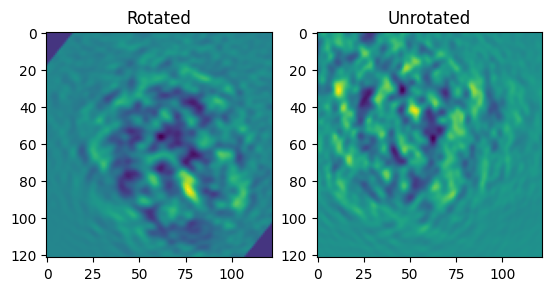

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


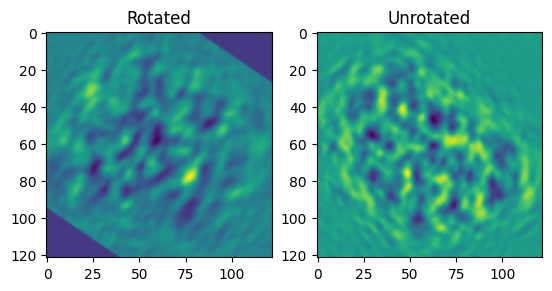

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


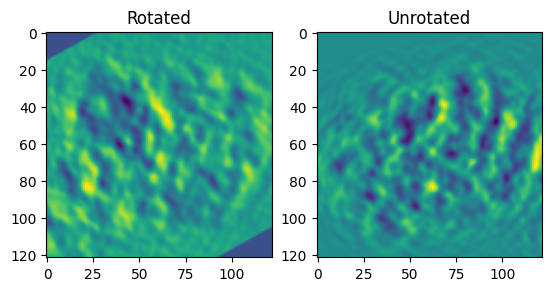

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


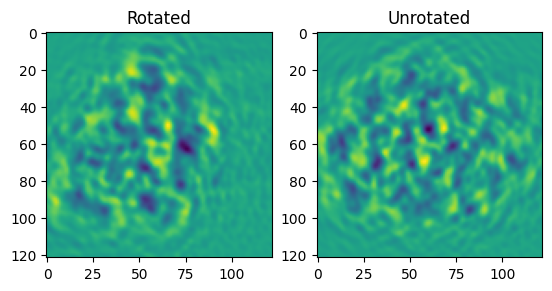

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


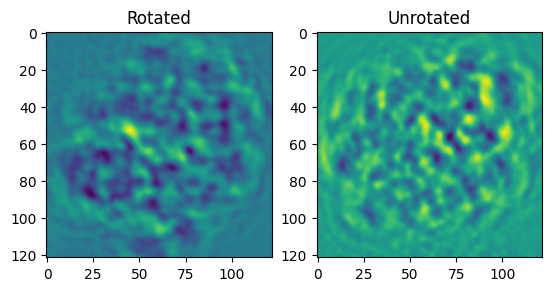

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


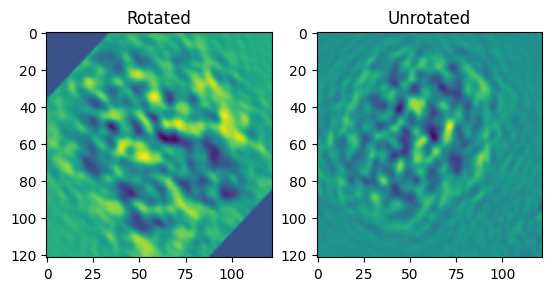

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


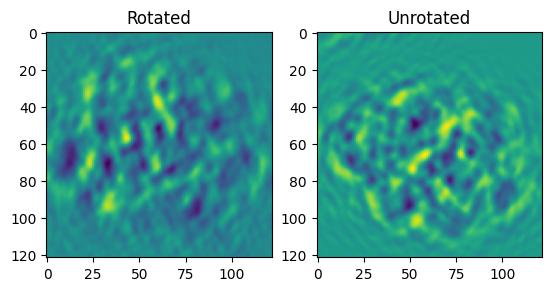

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


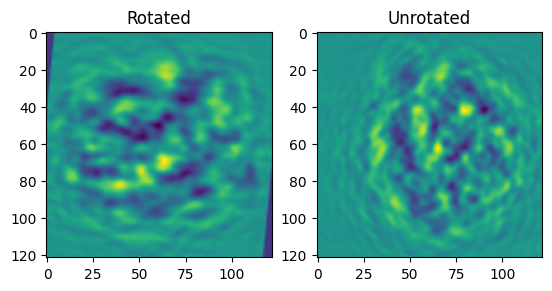

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


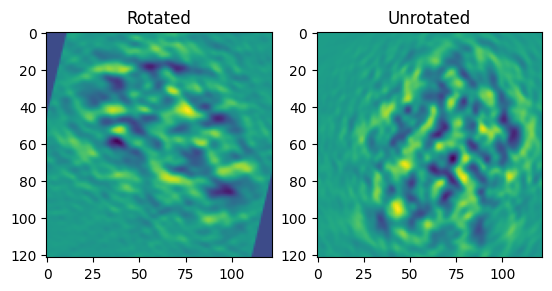

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


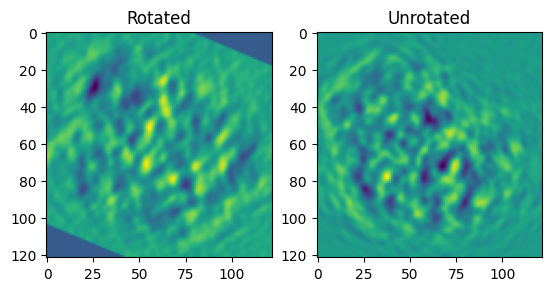

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


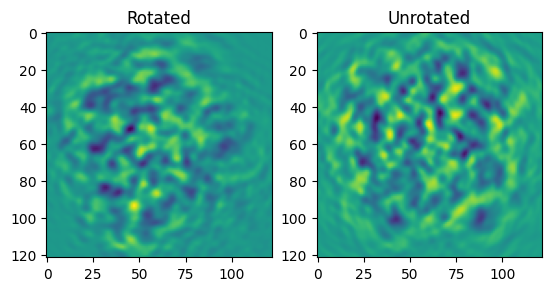

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


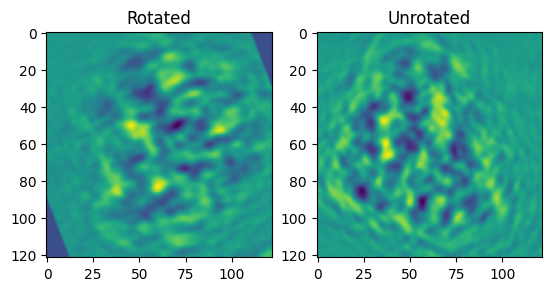

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


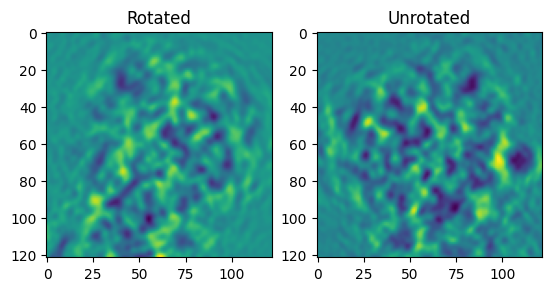

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


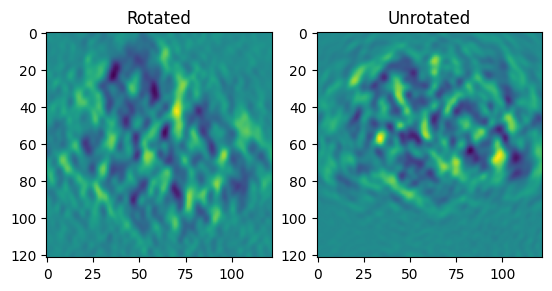

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


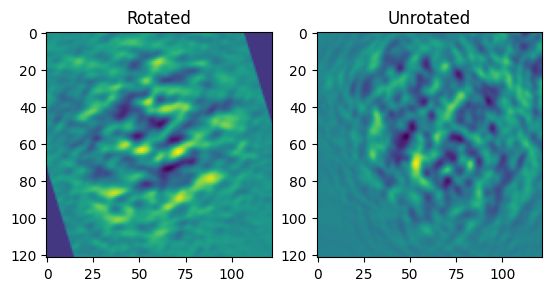

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


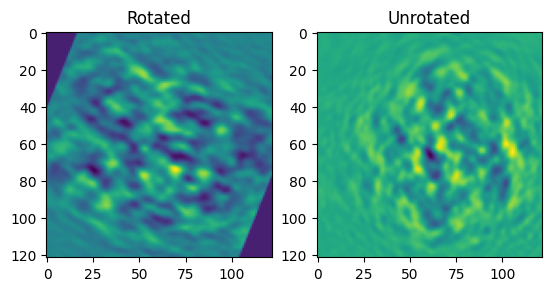

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


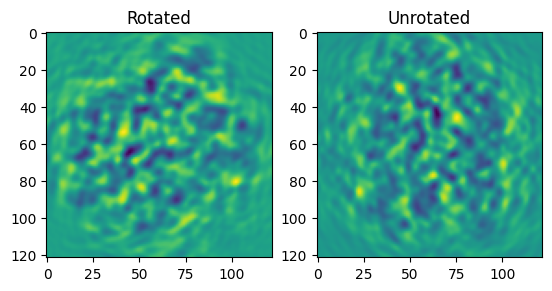

torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([3, 122, 122, 122])


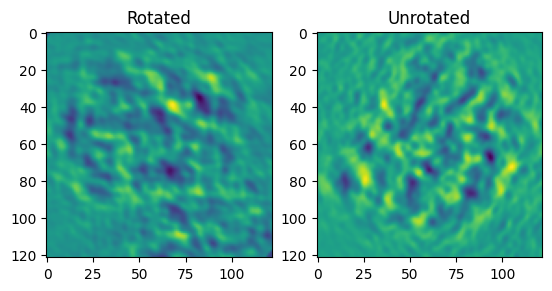

In [87]:
average = torch.zeros((122, 122, 122))
for subtomo, picked_part, pixel_coord in zip(new_out, picked_coords[:,-3:], new_pixel_coords[:, :3]):
    print(subtomo.shape, picked_part.shape)
    #rmat = angles_to_matrix( torch.Tensor(-1 * picked_part[-3:].numpy()[::-1])) #need to use angles here
    rmat = angles_to_matrix(picked_part[-3:])
    inverse_rmat = torch.linalg.inv(rmat)
    padded = torch.nn.functional.pad(subtomo, (0,0,0,0, ribo_pixel_radius, ribo_pixel_radius), mode = 'constant', value = 0)
    meshgrid, x_linspace, y_linspace, z_linspace = new_meshgrid(padded.shape, pixel_coord) #picked_part[:3])
    x = torch.flatten(meshgrid[0])
    y = torch.flatten(meshgrid[1])
    z = torch.flatten(meshgrid[2])
    before_rotation = torch.stack([x, y, z])
    rotation = torch.matmul(inverse_rmat, torch.stack([z, y, x]))

    center_diff = pixel_coord - torch.round(pixel_coord)

    in_grid_shape = torch.unflatten(rotation, dim = 1, sizes = (padded.shape[0],
                                                      padded.shape[1],
                                                      padded.shape[2]))[:,
                                                                        int(padded.shape[0]/2 - ribo_pixel_radius):  int(padded.shape[0]/2 + ribo_pixel_radius), 
                                                                        int(padded.shape[1]/2 - ribo_pixel_radius):  int(padded.shape[1]/2 + ribo_pixel_radius),
                                                                        int(padded.shape[2]/2 - ribo_pixel_radius):  int(padded.shape[2]/2 + ribo_pixel_radius)]
    print(in_grid_shape.shape)
    data_w_coords = scipy.interpolate.RegularGridInterpolator((z_linspace.numpy(), y_linspace.numpy(), x_linspace.numpy()), padded.numpy())

    #apply spherical mask, does it matter before or after interpolation and rotation?
    mask = torch.where(torch.sqrt(in_grid_shape[0]**2 + in_grid_shape[1]**2 + in_grid_shape[2]**2) < ribo_pixel_radius, 1, 0)
    #print(mask.shape, 'MASK SHAPE')
    
    interpolation = data_w_coords((in_grid_shape[0].numpy(),
                                  in_grid_shape[1].numpy(),
                                    in_grid_shape[2].numpy()))
    
    fig, axs = plt.subplots(nrows = 1, ncols = 2)
    average = average + interpolation[:, :, :]
    axs[0].imshow(interpolation[61,:, :]) # need to apply spherical mask
    axs[0].set_title("Rotated")
    axs[1].imshow(subtomo[int(subtomo.shape[0]/2),
                       int(subtomo.shape[1]/2  - ribo_pixel_radius) : int(subtomo.shape[1]/2  + ribo_pixel_radius),
                       int(subtomo.shape[2]/2  - ribo_pixel_radius) : int(subtomo.shape[2]/2  + ribo_pixel_radius)])
    axs[1].set_title("Unrotated")
    plt.show()
    """
    print(interpolation.shape, "interpolation shape")
    print(meshgrid[0].shape,
         meshgrid[1].shape,
         meshgrid[2].shape)
    print(in_grid_shape.shape)
    plt.scatter(meshgrid[0][::4, ::4].numpy(), meshgrid[1][::4, ::4].numpy(), s = 1.0)
    plt.scatter(in_grid_shape[0][::4,::4].numpy(), in_grid_shape[1][::4, ::4].numpy(), c= 'r', s = 1.0)
    plt.show()
    plt.scatter(meshgrid[1][::4, ::4].numpy(), meshgrid[2][::4, ::4].numpy(), s = 1.0)
    plt.scatter(in_grid_shape[1][::4,::4].numpy(), in_grid_shape[2][::4, ::4].numpy(), c= 'r', s = 1.0)
    plt.show()
    #plt.imshow(padded_subtomo[100,:,:])
    #plt.show()
    #print(np.shape(interpolation))
    """

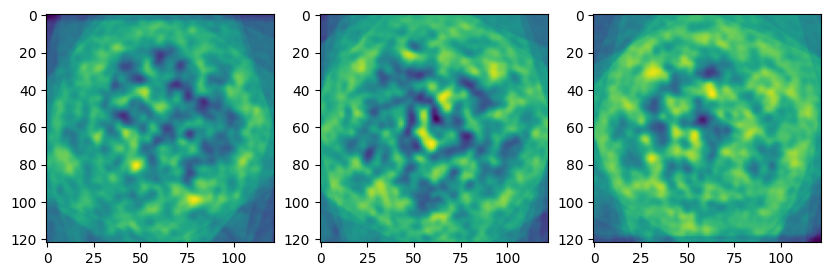

In [96]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 20))
axs[0].imshow(average[40, :, :].numpy() / new_out.shape[0])
axs[1].imshow(average[60,:, :].numpy() / new_out.shape[0])
axs[2].imshow(average[80,:, :].numpy() / new_out.shape[0])


In [111]:
import mrcfile
mrc = mrcfile.new("averaged.mrc")
mrc.set_data(average.numpy().astype(np.float32))
mrc.close()

## Now try at rotating the meshgrids

In [112]:
## Think about the missing wedge mask
#tilt axis is y
i = 0
for subtomo, picked_part, pixel_coord in zip(new_out[:5], picked_coords[:,-3:], new_pixel_coords[:, :3]):
    print(subtomo.shape, picked_part.shape)
    mrc = mrcfile.new("subtomo" + str(i) + ".mrc")
    mrc.set_data(subtomo.numpy().astype(np.float32))
    mrc.close()
    i+= 1
    #subtomo shape is z, y, x, 
    #so missing wedge is based on the length of the x dimension and the x pixel coordinate
    #plt.imshow(torch.abs(torch.fft.fftshift(torch.fft.fftn(subtomo))).numpy()[61,:, :], vmax = 5000, cmap = 'gray')
    #plt.show




torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([122, 244, 244]) torch.Size([3])
torch.Size([122, 244, 244]) torch.Size([3])


In [ ]:
average = torch.zeros((122, 122, 122))
for subtomo, picked_part, pixel_coord in zip(new_out, picked_coords[:,-3:], new_pixel_coords[:, :3]):
    print(subtomo.shape, picked_part.shape)
    #rmat = angles_to_matrix( torch.Tensor(-1 * picked_part[-3:].numpy()[::-1])) #need to use angles here
    rmat = angles_to_matrix(picked_part[-3:])
    inverse_rmat = torch.linalg.inv(rmat)
    padded = torch.nn.functional.pad(subtomo, (0,0,0,0, ribo_pixel_radius, ribo_pixel_radius), mode = 'constant', value = 0)
    meshgrid, x_linspace, y_linspace, z_linspace = new_meshgrid(padded.shape, pixel_coord) #picked_part[:3])
    x = torch.flatten(meshgrid[0])
    y = torch.flatten(meshgrid[1])
    z = torch.flatten(meshgrid[2])
    before_rotation = torch.stack([x, y, z])
    rotation = torch.matmul(inverse_rmat, torch.stack([z, y, x]))

    center_diff = pixel_coord - torch.round(pixel_coord)

    in_grid_shape = torch.unflatten(rotation, dim = 1, sizes = (padded.shape[0],
                                                      padded.shape[1],
                                                      padded.shape[2]))[:,
                                                                        int(padded.shape[0]/2 - ribo_pixel_radius):  int(padded.shape[0]/2 + ribo_pixel_radius), 
                                                                        int(padded.shape[1]/2 - ribo_pixel_radius):  int(padded.shape[1]/2 + ribo_pixel_radius),
                                                                        int(padded.shape[2]/2 - ribo_pixel_radius):  int(padded.shape[2]/2 + ribo_pixel_radius)]
    print(in_grid_shape.shape)
    data_w_coords = scipy.interpolate.RegularGridInterpolator((z_linspace.numpy(), y_linspace.numpy(), x_linspace.numpy()), padded.numpy())

    #apply spherical mask, does it matter before or after interpolation and rotation?
    mask = torch.where(torch.sqrt(in_grid_shape[0]**2 + in_grid_shape[1]**2 + in_grid_shape[2]**2) < ribo_pixel_radius, 1, 0)
    #print(mask.shape, 'MASK SHAPE')
    
    interpolation = data_w_coords((in_grid_shape[0].numpy(),
                                  in_grid_shape[1].numpy(),
                                    in_grid_shape[2].numpy()))
    
    fig, axs = plt.subplots(nrows = 1, ncols = 2)
    average = average + interpolation[:, :, :]
    axs[0].imshow(interpolation[61,:, :]) # need to apply spherical mask
    axs[0].set_title("Rotated")
    axs[1].imshow(subtomo[int(subtomo.shape[0]/2),
                       int(subtomo.shape[1]/2  - ribo_pixel_radius) : int(subtomo.shape[1]/2  + ribo_pixel_radius),
                       int(subtomo.shape[2]/2  - ribo_pixel_radius) : int(subtomo.shape[2]/2  + ribo_pixel_radius)])
    axs[1].set_title("Unrotated")
    plt.show()
    """
    print(interpolation.shape, "interpolation shape")
    print(meshgrid[0].shape,
         meshgrid[1].shape,
         meshgrid[2].shape)
    print(in_grid_shape.shape)
    plt.scatter(meshgrid[0][::4, ::4].numpy(), meshgrid[1][::4, ::4].numpy(), s = 1.0)
    plt.scatter(in_grid_shape[0][::4,::4].numpy(), in_grid_shape[1][::4, ::4].numpy(), c= 'r', s = 1.0)
    plt.show()
    plt.scatter(meshgrid[1][::4, ::4].numpy(), meshgrid[2][::4, ::4].numpy(), s = 1.0)
    plt.scatter(in_grid_shape[1][::4,::4].numpy(), in_grid_shape[2][::4, ::4].numpy(), c= 'r', s = 1.0)
    plt.show()
    #plt.imshow(padded_subtomo[100,:,:])
    #plt.show()
    #print(np.shape(interpolation))
    """